<a href="https://colab.research.google.com/github/deburky/boosting-scorecards/blob/main/other_notebooks/catboost_hidden_tricks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hidden Tricks in CatBoost You Should Know
## Advanced explainability, feature selection, and full MLflow deployment on AWS SageMaker

A notebook with examples from the corresponding Medium article.

Author: https://github.com/deburky

In [2]:
import sys
ENV_COLAB = 'google.colab' in sys.modules

if ENV_COLAB:
    !pip install catboost shap ipywidgets -qU
    !jupyter nbextension enable --py widgetsnbextension

    print('Environment: Google Colab')
else:
  print('Environment: Local')
  !pip install pandas numpy catboost shap matplotlib -qU

import pandas as pd
from catboost import CatBoostClassifier, Pool
import shap
import numpy as np
import shap
from matplotlib import pyplot as plt

%config InlineBackend.figure_format = 'retina'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 89.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 60.9 MB/s eta 0:00:00
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK
Environment: Google Colab


## Explainability

### CatBoost SHAP

In [32]:
# Sample data with categorical features
X = pd.DataFrame({
    'age': [25, 35, 45, 30, 50],
    'city': ['NYC', 'LA', 'Chicago', 'NYC', 'Boston'],
    'education': ['Bachelor', 'Master', 'PhD', 'High School', 'Bachelor'],
    'income': [50000, 75000, 95000, 40000, 80000]
})
y = [0, 1, 1, 0, 1]  # binary target

cat_features = ['city', 'education']

model = CatBoostClassifier(verbose=False)
pool = Pool(X, y, cat_features=cat_features)
model.fit(pool)

# Get feature names
feature_names = model.feature_names_

shap_vals = model.get_feature_importance(
    pool,
    type="ShapValues"
)

# Build SHAP DataFrame
shap_df = pd.DataFrame(
    shap_vals[:, :-1],  # drop expected value column
    columns=feature_names
)

# Add base prediction column
shap_df["base_value"] = shap_vals[:, -1]

# Optionally add predicted value column
shap_df["pred"] = shap_df[feature_names].sum(axis=1) + shap_df["base_value"]

shap_df.head()

,age,city,education,income,base_value,pred
0,-0.400790,-0.749880,-0.008432,-0.414022,0.409026,-1.164098
1,0.232421,0.473768,-0.083560,0.272941,0.409026,1.304596
2,0.271368,0.457291,-0.085888,0.311781,0.409026,1.363577
3,-0.374000,-0.730237,0.028360,-0.454624,0.409026,-1.121475
4,0.279378,0.454179,-0.033372,0.304405,0.409026,1.413615


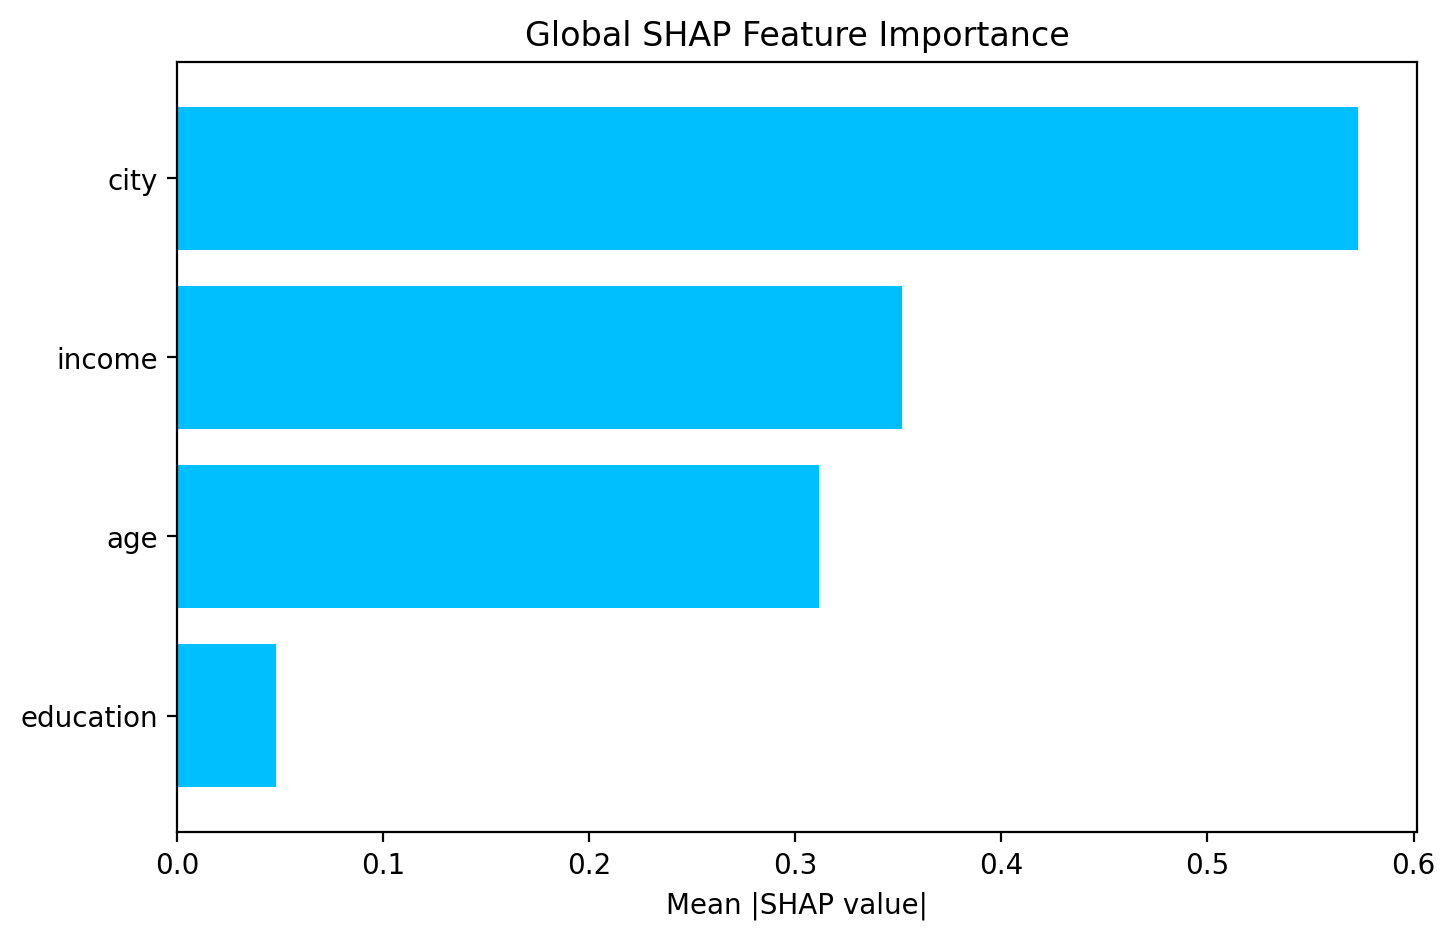

In [4]:
abs_mean = shap_df[feature_names].abs().mean().sort_values()
abs_mean.plot(kind="barh", figsize=(8,5), width=0.8, color="deepskyblue")
plt.xlabel("Mean |SHAP value|")
plt.title("Global SHAP Feature Importance")
plt.savefig("shap_importance.png", dpi=300)
plt.show()

### SHAP for categorical features with CatBoost

/tmp/ipython-input-2668590890.py:10: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


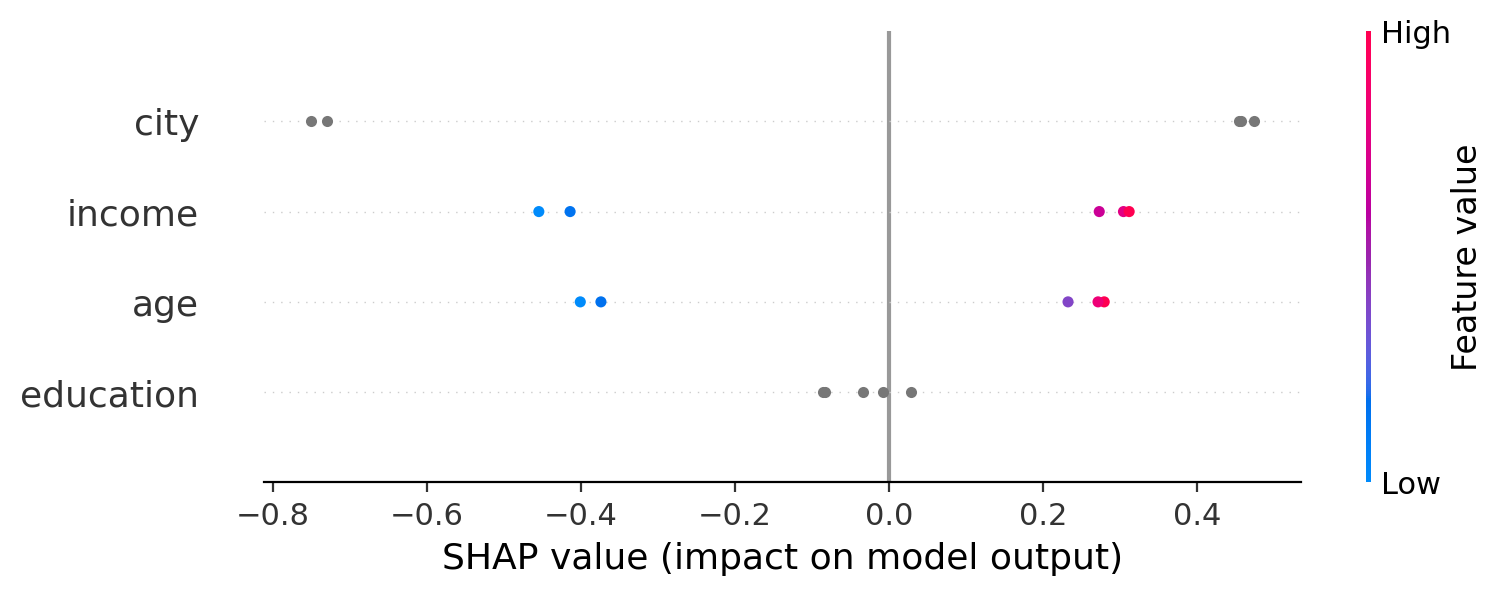

In [33]:
# Separate bias term and features
shap_values_no_bias = shap_vals[:, :-1]  # all features, no base value

# Convert X to the same format shap expects
X_for_shap = X.copy()
X_for_shap.columns = feature_names

# Beeswarm plot
fig = plt.figure()
shap.summary_plot(
    shap_values_no_bias,
    X_for_shap,
    plot_type="dot",
    color_bar=True,
    show=False
)
plt.show()

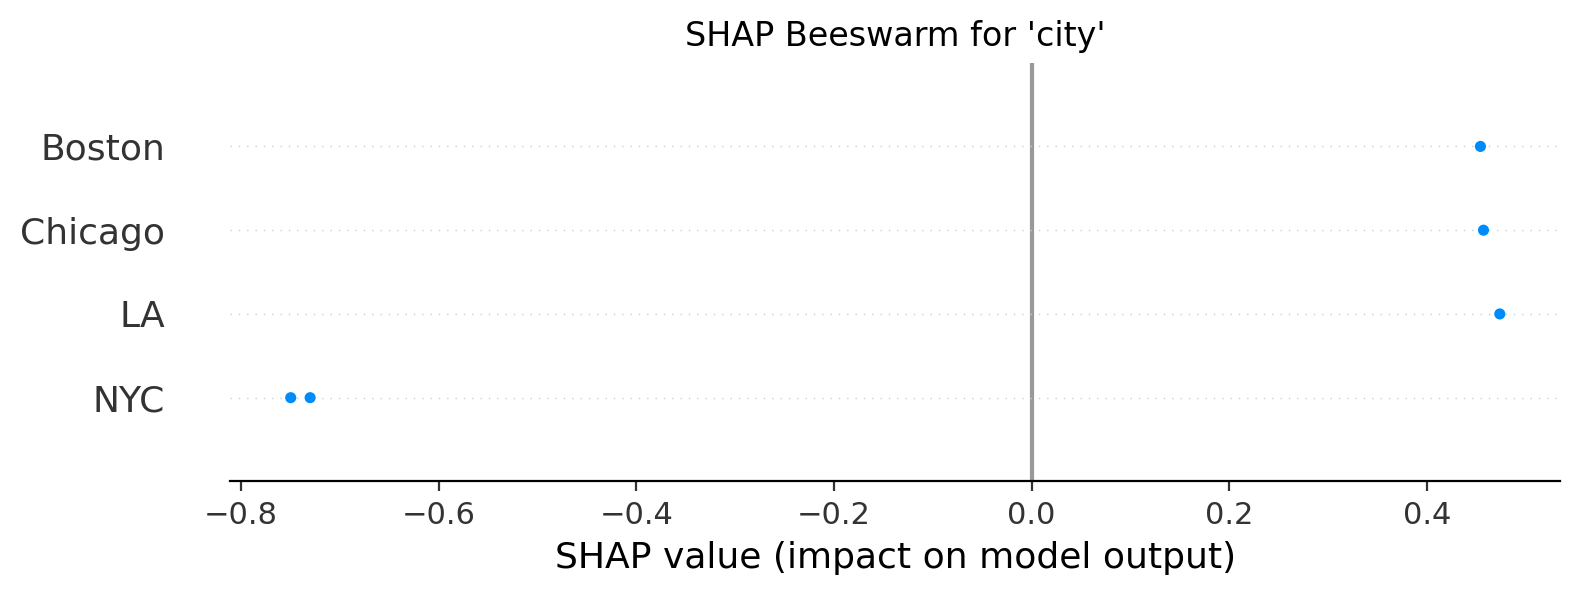

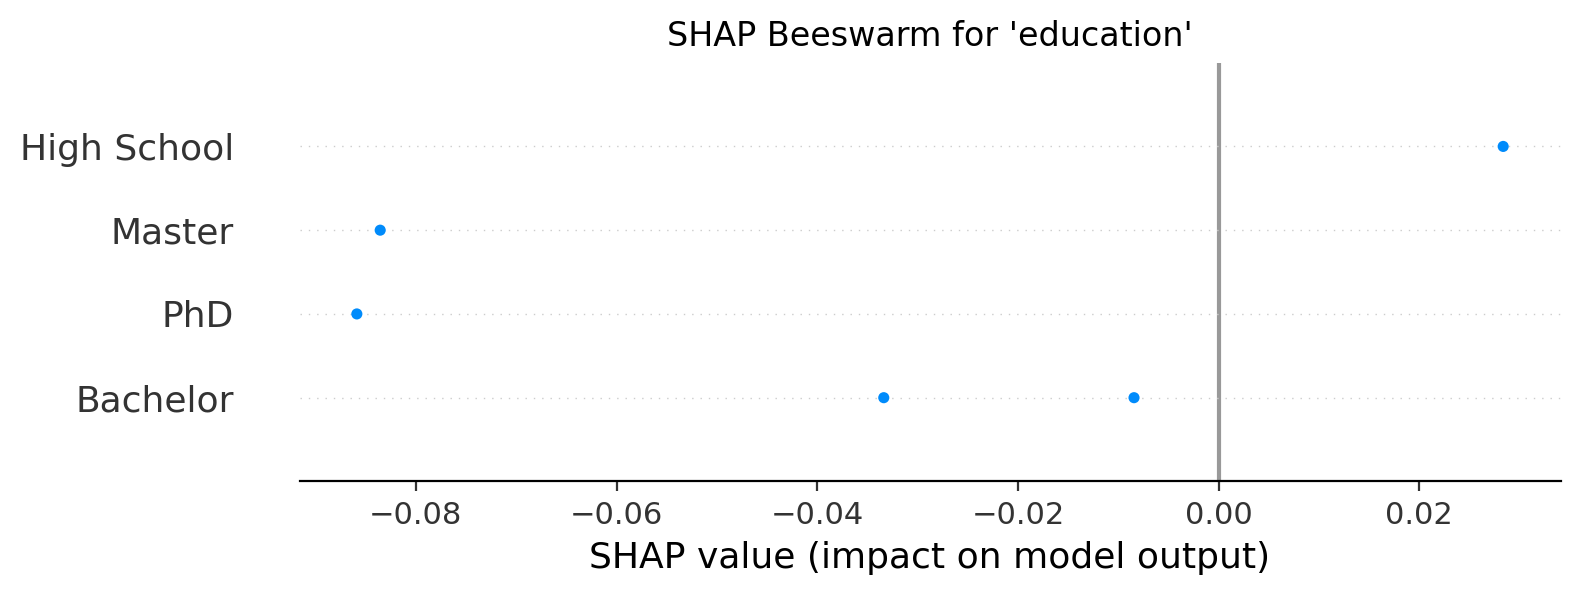

In [34]:
def plot_shap_categorical(shap_vals, X_data, feature_name, max_display=5):
    # Use CatBoost's SHAP values directly (no need for TreeExplainer)
    shap_values_no_bias = shap_vals[:, :-1]
    feature_names = X_data.columns.tolist()

    # Get column index for the target feature
    feature_idx = feature_names.index(feature_name)
    feature_values = shap_values_no_bias[:, feature_idx]
    feature_data = X_data[feature_name]

    # Get unique categories and sort by mean absolute SHAP value
    unique_categories = np.array(feature_data.unique())
    sorted_idx = np.argsort([
        np.nanmean(np.abs(feature_values[feature_data == cat]))
        for cat in unique_categories
    ])[::-1]
    unique_categories = unique_categories[sorted_idx]

    # Limit categories if necessary
    if len(unique_categories) > max_display:
        unique_categories = unique_categories[:max_display]

    # Split SHAP values by categories
    new_shap_values = [feature_values[feature_data == cat] for cat in unique_categories]

    # Pad arrays to uniform shape
    max_len = max(len(v) for v in new_shap_values)
    new_shap_values = [
        np.pad(v, (0, max_len - len(v)), constant_values=np.nan)
        for v in new_shap_values
    ]
    new_shap_values = np.array(new_shap_values).T

    # Create SHAP Explanation object
    shap_values_feature = shap.Explanation(
        values=new_shap_values,
        data=np.zeros_like(new_shap_values),
        base_values=np.zeros(max_len),
        feature_names=[str(cat) for cat in unique_categories],
    )

    # Plot beeswarm for the categorical feature
    plt.figure(figsize=(8, 4))
    shap.plots.beeswarm(shap_values_feature, color_bar=False, show=False)
    plt.title(f"SHAP Beeswarm for '{feature_name}'")
    plt.tight_layout()
    plt.show()


# Plot categorical features
plot_shap_categorical(shap_vals, X, "city")
plot_shap_categorical(shap_vals, X, "education")

## Feature selection

CatBoost offers a comprehensive suite for feature statistics and feature selection. Below we showcase a few examples of this functionality.

### Feature statistics

Imagine you want to understand the binning of your features and want to see how predictions match the observed rates. This is what [`calc_feature_statistics`](https://catboost.ai/docs/en/concepts/python-reference_catboostregressor_calc_feature_statistics) function is designed for.

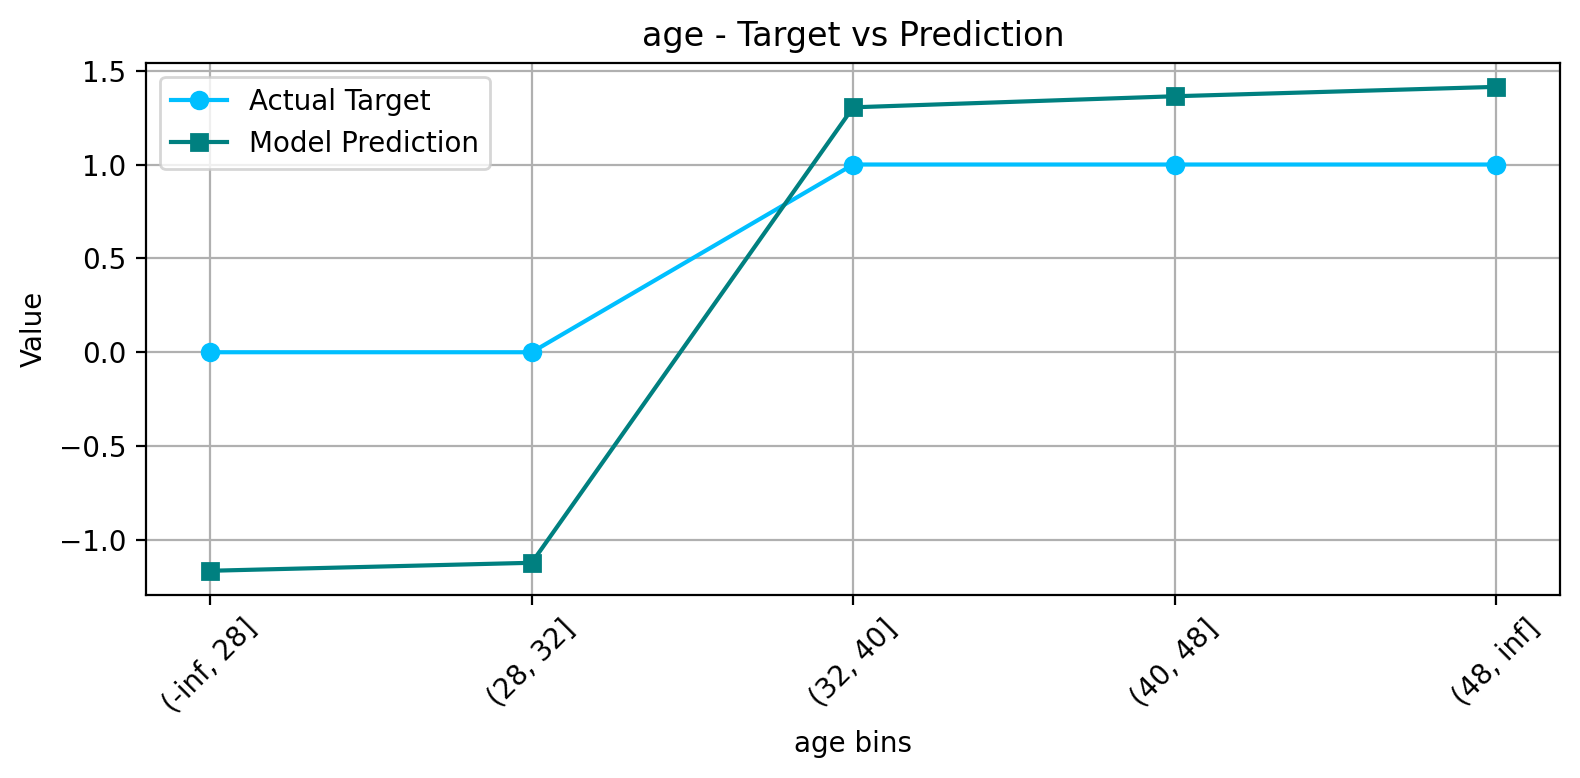

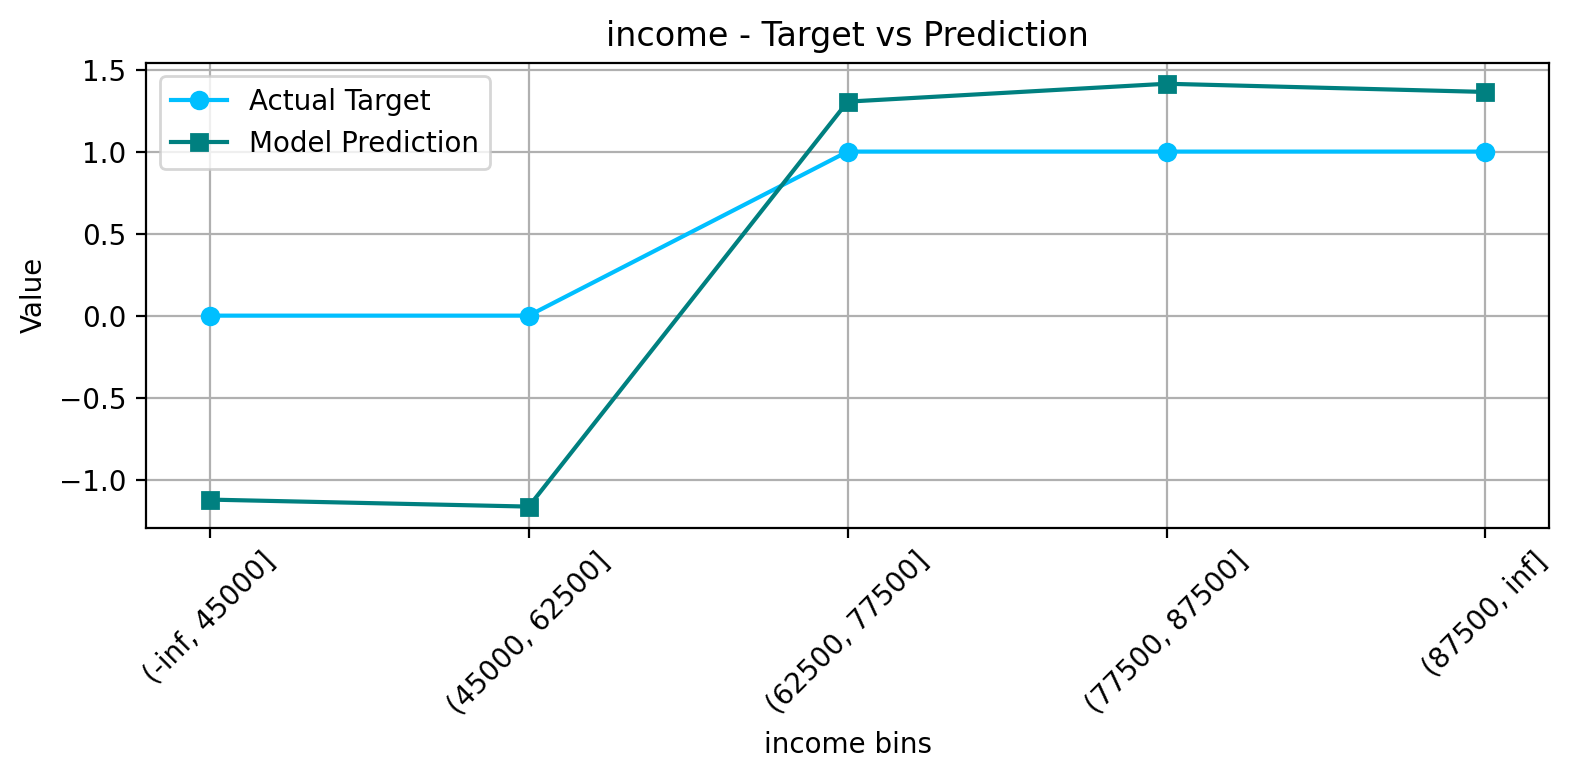

In [35]:
# JS Plot only shows in local notebooks
numerical_features = ["age", "income"]

if ENV_COLAB:  # https://github.com/catboost/catboost/issues/262
  stats = model.calc_feature_statistics(
      data=X, target=y, feature=numerical_features, plot=False
  )

  # Simple plot function
  def plot_feature_response(stats, feature_name):
      import numpy as np

      data = stats[feature_name]
      borders = data['borders']
      mean_target = data['mean_target']
      model_pred = data['mean_prediction']

      # Add -inf and +inf to build 5 bin ranges from 4 borders
      bin_edges = [-np.inf] + borders.tolist() + [np.inf]
      bin_labels = [f"({bin_edges[i]:.0f}, {bin_edges[i+1]:.0f}]" for i in range(len(bin_edges) - 1)]

      plt.figure(figsize=(8, 4))
      plt.plot(bin_labels, mean_target, 'o-', label='Actual Target', color='deepskyblue')
      plt.plot(bin_labels, model_pred, 's-', label='Model Prediction', color='teal')
      plt.title(f'{feature_name} - Target vs Prediction')
      plt.xlabel(f'{feature_name} bins')
      plt.ylabel('Value')
      plt.xticks(rotation=45)
      plt.legend()
      plt.grid(True)
      plt.tight_layout()
      plt.show()

  # Plot each feature
  for feature in numerical_features:
      plot_feature_response(stats, feature)

else:
  model.calc_feature_statistics(
      data=X,
      target=y,
      feature=numerical_features,
      plot=True
  )

In [40]:
# Categorical visualization
categorical_features = ['city', 'education']

try:
  model.calc_feature_statistics(
    data=X,
    target=y,
    feature=categorical_features,
    plot=True
  )
except Exception as e:
    print(f"Unexpected error: {e}")

Unexpected error: catboost/private/libs/quantized_pool_analysis/quantized_pool_analysis.cpp:570: Internal CatBoost Error (contact developers for assistance): Binarized statistics supported only for one-hot encoded features. Use one_hot_max_size when training to manage that.


In [44]:
import pandas as pd
from catboost import CatBoostClassifier, Pool

# Sample data with categorical features
X = pd.DataFrame({
    "age": [25, 35, 45, 30, 50],
    "city": ["NYC", "LA", "Chicago", "NYC", "Boston"],
    "education": ["Bachelor", "Master", "PhD", "High School", "Bachelor"],
    "income": [50000, 75000, 95000, 40000, 80000],
})
y = [0, 1, 1, 0, 1]  # binary target

cat_features = ["city", "education"]

model = CatBoostClassifier(verbose=False, one_hot_max_size=8)
pool = Pool(X, y, cat_features=cat_features)
model.fit(pool)

try:
  model.calc_feature_statistics(
      data=X,
      target=y,
      feature=cat_features,
      max_cat_features_on_plot=50,
      plot=True
  )
except Exception as e:
    print(f"Unexpected error: {e}")

### Feature selection

CatBoost provides a useful suite of feature selection algorithms that can automatically identify the most important features for your model based on different criteria. See [this CatBoost repo source](https://github.com/catboost/tutorials/tree/master/feature_selection) for more details.

In [9]:
from catboost import EShapCalcType, EFeaturesSelectionAlgorithm


def select_features_catboost(X_data, y_data, cat_features, algorithm, top_n=3):
    # Create pools
    train_pool = Pool(X_data, y_data, cat_features=cat_features)

    # Simple feature selection
    model_selector = CatBoostClassifier(
        iterations=50, random_seed=42, verbose=False
    )
    summary = model_selector.select_features(
        train_pool,
        features_for_select=list(range(X_data.shape[1])),
        num_features_to_select=top_n,
        algorithm=algorithm,
        shap_calc_type=EShapCalcType.Regular,
        train_final_model=True,
        logging_level="Silent",
        plot=False,
    )

    # Get selected feature names
    selected_indices = summary["selected_features"]
    selected_names = [X_data.columns[i] for i in selected_indices]

    print(f"Algorithm: {algorithm}")
    print(f"Selected features: {selected_names}")
    print(f"Selected indices: {selected_indices}")
    return summary


shap_summary = select_features_catboost(
    X, y, cat_features,
    EFeaturesSelectionAlgorithm.RecursiveByShapValues
)

loss_summary = select_features_catboost(
    X, y, cat_features,
    EFeaturesSelectionAlgorithm.RecursiveByLossFunctionChange
)

pred_summary = select_features_catboost(
    X, y, cat_features,
    EFeaturesSelectionAlgorithm.RecursiveByPredictionValuesChange
)

Algorithm: EFeaturesSelectionAlgorithm.RecursiveByShapValues
Selected features: ['age', 'city', 'income']
Selected indices: [0, 1, 3]
Algorithm: EFeaturesSelectionAlgorithm.RecursiveByLossFunctionChange
Selected features: ['age', 'city', 'income']
Selected indices: [0, 1, 3]
Algorithm: EFeaturesSelectionAlgorithm.RecursiveByPredictionValuesChange
Selected features: ['age', 'city', 'income']
Selected indices: [0, 1, 3]


## Embeddings

One of the lesser known features of CatBoost is its support for additional input feature types such as text and embeddings. Below we show a few use cases for the use of text string data and multidimensional embedding vectors.

### Text features

Sometimes you may want to leverage text descriptions in your model, for example product description, customer feedback, customer support chats etc. Instead of computing embeddings or using techniques like n-grams and TF-IDF, you can pass your text features directly into CatBoost's [`text_features`](https://catboost.ai/docs/en/features/text-features) parameter.

In [31]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool

# Expanded dataset with text and embeddings
np.random.seed(42)

texts = [
    'This is a simple short text about data science and analytics',
    'Here we have a longer text with more words and detailed content about machine learning algorithms',
    'Brief note on artificial intelligence and neural networks in modern applications',
    'Medium length text with some interesting content about deep learning and transformers',
    'Another example of text data for classification tasks in natural language processing',
]

# Duplicate texts
texts *= 5

categories = ['Tech', 'Science', 'Business', 'Education', 'Research']

X = pd.DataFrame({
    'age': np.random.randint(22, 65, 25),
    'category': np.random.choice(categories, 25),
    'text_field': texts,
})

# Create a realistic target
y = (
    (X['text_field'].str.len() > 120).astype(int) * 0.4 +
    (X['age'] > 45).astype(int) * 0.2 +
    (X['category'].isin(['Tech', 'Research'])).astype(int) * 0.4 +
    np.random.normal(0, 0.1, 25)
) > 0.5
y = y.astype(int)

# Text features only
pool_text = Pool(
    data=X,
    label=y,
    cat_features=['category'],
    text_features=['text_field']
)

model_text = CatBoostClassifier(
    task_type='GPU' if ENV_COLAB else 'CPU',
    iterations=100,
    verbose=False,
    random_seed=42
)
model_text.fit(pool_text)

print(f"Model accuracy: {model_text.score(pool_text):.3f}")
# Model accuracy: 0.960

Model accuracy: 0.960


### Embedding features

In [29]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool

# Sample text data
np.random.seed(42)

texts = [
    'This is a simple short text about data science',
    'Here we have a longer text with more words and detailed content about machine learning',
    'Brief note on artificial intelligence and neural networks',
    'Medium length text with some interesting content about deep learning and transformers',
    'Another example of text data for classification tasks in natural language processing',
]
texts *= 3

categories = ['Tech', 'Science', 'Business', 'Education', 'Research']
ages = np.random.randint(22, 65, 15)

X = pd.DataFrame({
    'age': ages,
    'category': np.random.choice(categories, 15),
    'text_field': texts,
    # Simulated embeddings
    'embedding': [np.random.normal(0, 1, 4).tolist() for _ in range(15)]
})

# Create realistic target based on text length and content
y = (
    (X['text_field'].str.len() > 100).astype(int) * 0.4 +
    (X['age'] > 40).astype(int) * 0.3 +
    (X['category'].isin(['Tech', 'Research'])).astype(int) * 0.3 +
    np.random.normal(0, 0.1, 15)
) > 0.5
y = y.astype(int)

# Define feature types
cat_features = ['category']
text_features = ['text_field']
embedding_features = ['embedding']

# Create Pool with embeddings
pool = Pool(
    data=X,
    label=y,
    cat_features=cat_features,
    text_features=text_features,
    embedding_features=embedding_features
)

# Train model (requires GPU for embeddings)
model = CatBoostClassifier(
    task_type='GPU' if ENV_COLAB else 'CPU',
    iterations=100,
    verbose=False,
    random_seed=42
)

model.fit(pool)

print("Model trained with text and embedding features!")
print(f"Feature names: {model.feature_names_}")
print(f"Predictions: {model.predict_proba(pool)[:, 1].round(3)}")
# Model trained with text and embedding features!
# Feature names: ['age', 'category', 'text_field', 'embedding']
# Predictions: [0.231 0.78  0.045 0.519 0.049 0.049 0.794 0.027 0.092 0.038 0.027 0.213
#  0.798 0.845 0.054]

Model trained with text and embedding features!
Feature names: ['age', 'category', 'text_field', 'embedding']
Predictions: [0.406 0.537 0.405 0.453 0.392 0.382 0.528 0.41  0.435 0.392 0.384 0.486
 0.467 0.474 0.382]
